In [0]:
from google.colab import files
uploaded = files.upload()

Saving Google_Stock_Price_Train.csv to Google_Stock_Price_Train.csv
Saving Google_Stock_Price_Test.csv to Google_Stock_Price_Test.csv


In [0]:
class Data:
    def __init__(self, file_path_train, file_path_test):
        self.df_train = pd.read_csv(file_path_train, index_col="Date", parse_dates=True)
        self.df_test = pd.read_csv(file_path_test, index_col="Date", parse_dates=True)

    def print_shape(self):
        print('train_shape:', self.df_train.shape, 'test_shape:', self.df_test.shape)

    def preprocess(self, timesteps):
        # Parse the 'Close' column & remove ','
        train_set = self.df_train.iloc[:, 3:4].replace(',','', regex=True).values
        test_set = self.df_test.iloc[:, 3:4].replace(',','', regex=True).values
        
        # Convert dtype to float
        train_set = train_set.astype(np.float)
        test_set = test_set.astype(np.float)
        total_set = np.concatenate((train_set, test_set))
        inputs = total_set[len(total_set) - len(test_set) - timesteps: ]

        # Normalizing the train_set & test_set
        sc = MinMaxScaler()
        train_set_scaled = sc.fit_transform(train_set)
        test_set_scaled = sc.transform(inputs)

        # Construct the inputs & labels (labels start from the timestep-th day)
        rows_train, rows_test = train_set.shape[0], test_set.shape[0]
        X_train, y_train, X_test = [], [], []

        for i in range(timesteps, rows_train):
            X_train.append(train_set_scaled[i-timesteps:i, 0])
            y_train.append(train_set_scaled[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)

        for i in range(timesteps, timesteps + rows_test):
            X_test.append(test_set_scaled[i-timesteps:i, 0])

        X_test = np.array(X_test)

        # Reshaping
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
        print('X_test shape:', X_test.shape)


        return X_train, y_train, X_test, test_set, sc

In [0]:
class Model:
    def __init__(self):
        self.model = Sequential()

    def build_model(self):
        # Units: memory units; None: any time step; 1: one column of input
        self.model.add(LSTM(units = 50, return_sequences = True, input_shape = (None, 1)))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(units = 50, return_sequences = True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(units = 50, return_sequences = True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(units = 50))
        self.model.add(Dropout(0.2))

        # Unit = dimensions of the output
        self.model.add(Dense(units = 1))

        # Compile all the layers into a single system.   (RMSprop is memory heavy)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    def fit(self, X, Y, BatchSize, Epochs):
        # Train the model
        self.model.fit(X, Y, batch_size = BatchSize, epochs = Epochs, verbose = 0)
    
    def get_predict(self, X):
        return self.model.predict(X)

Using TensorFlow backend.


train_shape: (1258, 5) test_shape: (20, 5)
timesteps:  1
X_train shape: (1257, 1, 1) y_train shape: (1257,)
X_test shape: (20, 1, 1)


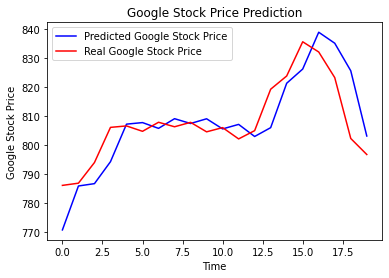

timesteps:  30
X_train shape: (1228, 30, 1) y_train shape: (1228,)
X_test shape: (20, 30, 1)


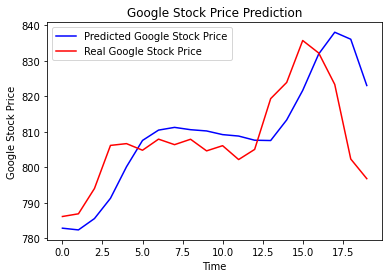

timesteps:  60
X_train shape: (1198, 60, 1) y_train shape: (1198,)
X_test shape: (20, 60, 1)


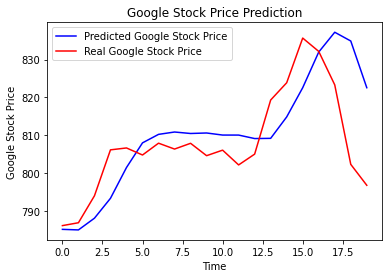

timesteps:  100
X_train shape: (1158, 100, 1) y_train shape: (1158,)
X_test shape: (20, 100, 1)


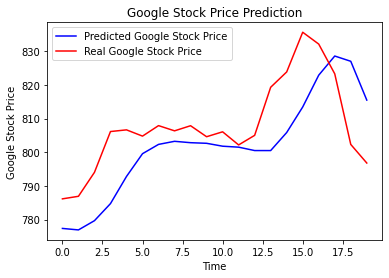

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt

def polt(X, Y):    
    plt.plot(X, color = 'blue', label = 'Predicted Google Stock Price')
    plt.plot(Y, color = 'red', label = 'Real Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def run(timesteps, data_instance):
    print('timesteps: ', timesteps)

    # Get processed data
    X_train, y_train, X_test, y_test, sc = data_instance.preprocess(timesteps)

    # Build & train the model
    model = Model()
    model.build_model()
    model.fit(X_train, y_train, 32, 100)

    # Get prediction
    predicted_stock_price = model.get_predict(X_test)

    # Inverse transform into original scale    
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    # Plot
    polt(predicted_stock_price, y_test)

def main():
    # Load & preprocess the data
    train_path, test_path = "Google_Stock_Price_Train.csv", "Google_Stock_Price_Test.csv"
    data_instance= Data(train_path, test_path)
    data_instance.print_shape()

    # Train & predict model with different timesteps dataset
    timesteps_list = [1, 30, 60, 100]
    for timesteps in timesteps_list:
        run(timesteps, data_instance)


    
if __name__ == '__main__':
    main()